## Environment set up and import Libraries

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
with tf.device(device_name):
  print(device_name.split(":")[1]," running . . . ")

GPU  running . . . 


In [35]:
import os,sys
import numpy as np
import random

random.seed(1)
np.random.seed(1)
tf.random.set_seed(2)

In [36]:
import os, keras, numpy
import matplotlib.pyplot as plt
from numpy import *
from numpy.random import *
from keras.datasets.fashion_mnist import load_data
from keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.layers import *

In [37]:
# randint(0, 5, 20)

## **Discriminator** Model

In [38]:
def define_discriminator(in_shape=(28,28,1), n_classes=5):

  # input level
  in_label = Input(shape=(1,), name = "input_label")
  li = Embedding(n_classes, 50)(in_label)
  li = Dense(in_shape[0] * in_shape[1])(li)
  li = Reshape((in_shape[0], in_shape[1], 1))(li)

  # input image
  in_image = Input(shape=in_shape, name = "input_image")

  # concate 1
  merge = Concatenate()([in_image, li])

  fe = Conv2D(128, (3,3), strides=(2,2), padding='same', activation = 'relu')(merge)

  # concate 2
  se1 = Embedding(n_classes, 50)(in_label)
  se1 = Dense(14*14, activation='relu')(se1)
  se1 = Reshape((14, 14, 1))(se1)

  merge1 = Concatenate()([fe, se1])

  fe = Conv2D(128, (3,3), strides=(2,2), padding='same', activation = 'relu')(merge1)
  fe = Flatten()(fe)
  fe = Dropout(0.2)(fe)
  
  # final layer
  out_layer = Dense(1, activation='sigmoid')(fe)

  model = Model([in_image, in_label], out_layer)

  opt = Adam(learning_rate= 3e-4, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model
a = define_discriminator()
a.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_label (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 1, 50)        250         ['input_label[0][0]']            
                                                                                                  
 dense_6 (Dense)                (None, 1, 784)       39984       ['embedding_3[0][0]']            
                                                                                                  
 input_image (InputLayer)       [(None, 28, 28, 1)]  0           []                               
                                                                                            

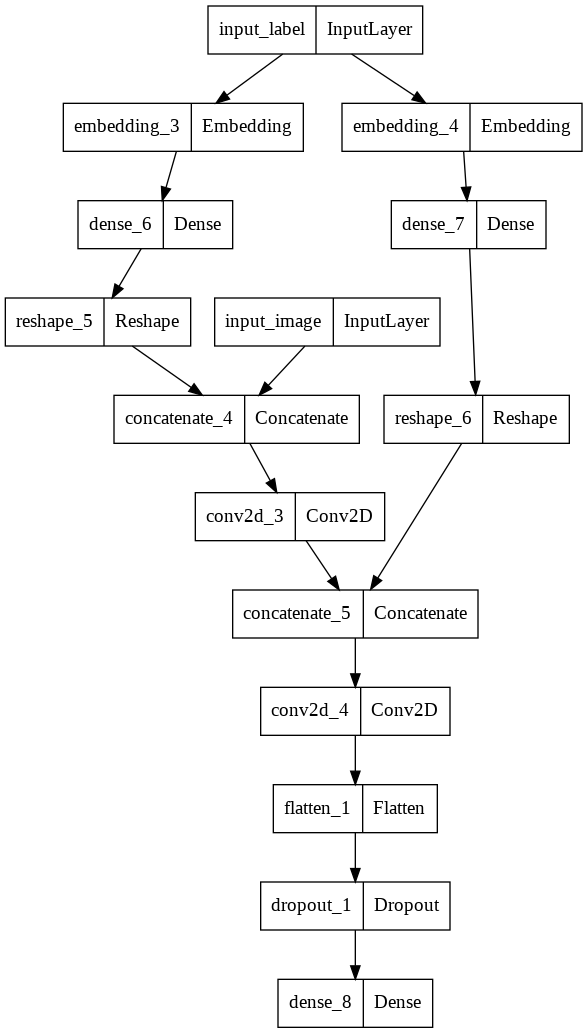

In [39]:
# plot the discriminator model
tf.keras.utils.plot_model(a)

## **Generator** Model

In [40]:
def define_generator(latent_dim = 100, n_classes=5):

  # label input
  in_label = Input(shape=(1,), name='in_label')
  li_embedd = Embedding(n_classes, 50)(in_label)
  li = Dense(7 * 7, activation='relu')(li_embedd)
  li = Reshape((7, 7, 1))(li)

  # latent input
  in_latent = Input(shape=(latent_dim,), name='in_latent')

  n_nodes = 128 * 7 * 7
  gen = Dense(n_nodes, activation = 'relu')(in_latent)
  gen = Reshape((7, 7, 128))(gen)

  # concate 1
  merge = Concatenate()([gen, li])

  gen = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', activation = 'relu')(merge)

  # concate 2
  se1 = Dense(14*14, activation='relu')(li_embedd)
  se1 = Reshape((14, 14, 1))(se1)
  merge1 = Concatenate()([gen, se1])
  gen = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', activation = 'relu')(merge1)

  # final layer
  out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)

  model = Model([in_latent, in_label], out_layer)
  return model
b = define_generator(100)
b.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 in_label (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 in_latent (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 1, 50)        250         ['in_label[0][0]']               
                                                                                                  
 dense_10 (Dense)               (None, 6272)         633472      ['in_latent[0][0]']              
                                                                                            

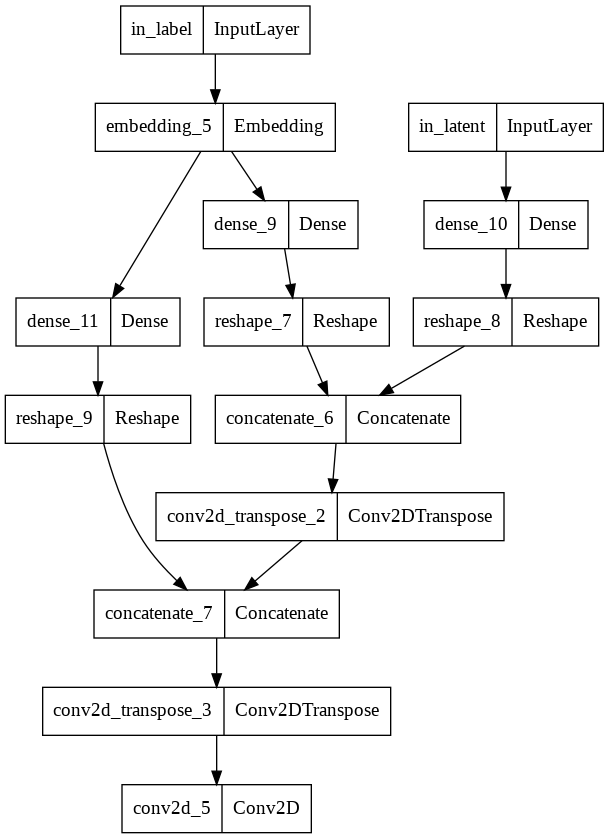

In [41]:
# plot the generator model
tf.keras.utils.plot_model(b)

## **Combine** or **GAN** Model

In [42]:
def define_gan(g_model, d_model):

  d_model.trainable = False

  gen_noise, gen_label = g_model.input
  gen_output = g_model.output

  gan_output = d_model([gen_output, gen_label])

  model = Model([gen_noise, gen_label], gan_output)

  opt = Adam(learning_rate= 3e-4, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt,  metrics=['accuracy'])
  
  return model
c = define_gan(b, a)
c.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 in_label (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 in_latent (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 1, 50)        250         ['in_label[0][0]']               
                                                                                                  
 dense_10 (Dense)               (None, 6272)         633472      ['in_latent[0][0]']              
                                                                                            

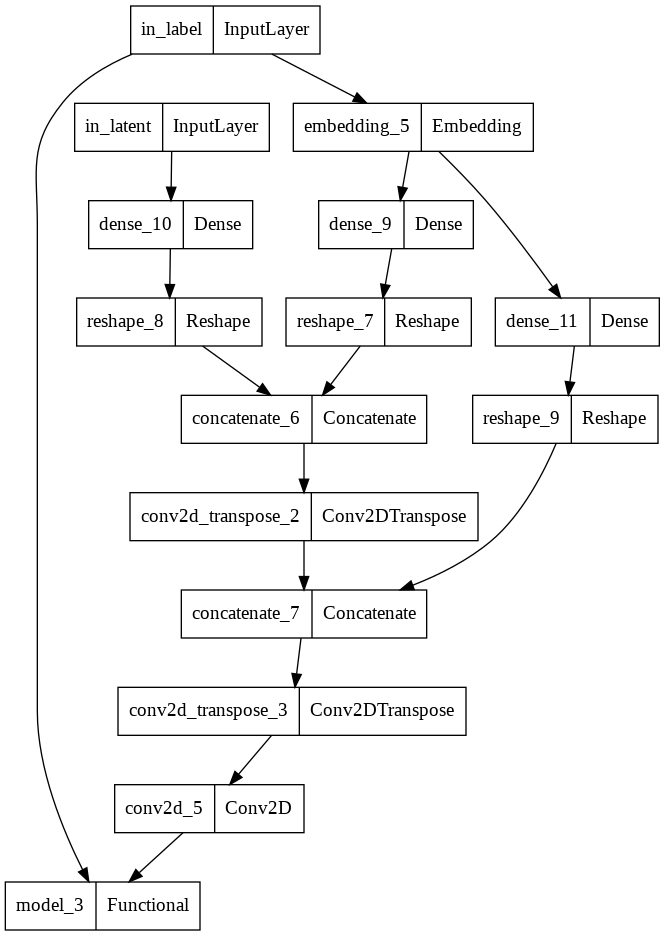

In [43]:
# plot GAN model
tf.keras.utils.plot_model(c)

## Load Mnist Dataset

In [44]:
def load_real_samples():
  # random.seed(1)
  # load dataset
  (trainX, trainy), (_, _) = mnist.load_data()
  trainy = randint(0, 5, trainX.shape[0])
  # expand to 3d, e.g. add channels
  X = expand_dims(trainX, axis=-1)
  X = X.astype('float32')
  # scale from [0,255] to [-1,1]
  X = (X - 127.5) / 127.5
  return [X, trainy]
k = load_real_samples()
print("image: ",k[0].shape," Lable: ",k[1].shape)
print("\nshape/size of the first 16 data: ",k[0][:16].shape)
print(k[1][:20])
print(k[1].shape)

image:  (60000, 28, 28, 1)  Lable:  (60000,)

shape/size of the first 16 data:  (16, 28, 28, 1)
[3 4 0 1 3 0 0 1 4 4 1 2 4 2 4 3 4 2 4 2]
(60000,)


## Plot data with label

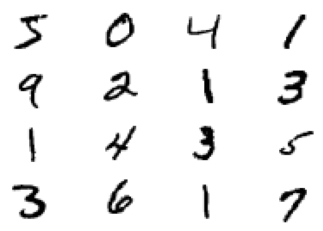

In [45]:
def save_plot(x_input,lebel,n=4):
    for i in range(n*n):
        plt.subplot(n, n, i+1)
        # plt.title(str(lebel[i]),fontsize=10,color="red",fontweight=10,pad='2.0',backgroundcolor='yellow')
        plt.imshow(x_input[i,:,:,0], cmap = 'gray_r')
        plt.axis('off')
    plt.show()
# plot data
save_plot(k[0][:16], k[1][:16])

## Generate real sample function

In [46]:
def generate_real_samples(dataset, n_samples):
	images, labels = dataset
	ix = randint(0, images.shape[0], n_samples)
	X, labels = images[ix], labels[ix]
	y = ones((n_samples, 1))
	return [X, labels], y
d = generate_real_samples(k, 32)
print("Generate real data as a batch randomly: ",d[0][0].shape)

Generate real data as a batch randomly:  (32, 28, 28, 1)


## Generate latent point function

In [47]:
def generate_latent_points(latent_dim, n_samples, n_classes=5):
  # random.seed(1)
  x_input = randn(latent_dim * n_samples)
  z_input = x_input.reshape(n_samples, latent_dim)
  labels = randint(0, n_classes, n_samples)
  return [z_input, labels]
p = generate_latent_points(100, 32)
print("Generate latent point(with label) as a batch: ",p[0].shape,p[1].shape)

Generate latent point(with label) as a batch:  (32, 100) (32,)


## Generate Fake samples of image with label

In [48]:
def generate_fake_samples(generator, latent_dim, n_samples):
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	images = generator.predict([z_input, labels_input])
	y = zeros((n_samples, 1))
	return [images, labels_input], y
with tf.device(device_name):
  kh = generate_fake_samples(b, 100, 32)
  print("shape of the generated images: ",kh[0][0].shape)

shape of the generated images:  (32, 28, 28, 1)


## Summarize the generator model

In [49]:
def summarize_the_model(generator,latent_dim = 100):
    latent_points, labels = generate_latent_points(latent_dim= 100, n_samples= 16)
    X  = generator.predict([latent_points, labels])
    # scale from [-1,1] to [0,1]
    # X = (X + 1) / 2.0
    save_plot(X, labels, n=4)

## Train function

In [50]:
def train(g_model, d_model, gan_model, dataset, latent_dim= 100, n_epochs=3, n_batch=128):
  # random.seed(1)

  print("No. of epoch: ",n_epochs)
  bat_per_epo = int(dataset[0].shape[0] / n_batch)
  print("batch per epoch: ", bat_per_epo)
  print("full batch: ",n_batch)
  half_batch = int(n_batch / 2)
  print("half batch: ", half_batch,'\n')
  print("*"*50,'\n\n')

  d_loss_real_array,d_loss_fake_array =[],[]
  g_loss_array = []
  for i in range(n_epochs):
    d_loss_r,d_loss_f = 0.0,0.0
    g_loss = 0.0
    
    for j in range(bat_per_epo):

      [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
      d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
      d_loss_r += d_loss1

      [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
      d_loss_f += d_loss2

      [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
      y_gan = ones((n_batch, 1))
      g_loss1,_ = gan_model.train_on_batch([z_input, labels_input], y_gan)
      g_loss += g_loss1

    d_loss_real_array.append(d_loss_r)
    d_loss_fake_array.append(d_loss_f)
    g_loss_array.append(g_loss)

    print('epoch -> [%d/%d], discriminator_loss_for_real_data = %.2f, discriminator_loss_for_fake_data = %.2f, generator_loss = %.2f\n' %(i+1, n_epochs, d_loss_r, d_loss_f, g_loss))
    summarize_the_model(g_model)
    # g_model.save("g_gan_model_"+str(i)+".h5")
    g_model.save("/content/drive/MyDrive/GAN_New_Approch/1/generator_model.h5")
    np.savez_compressed('/content/drive/MyDrive/GAN_New_Approch/1/loss_record.npz', a=d_loss_real_array, b=d_loss_fake_array, c=g_loss_array)

    print("\n")

  return d_loss_real_array, d_loss_fake_array, g_loss_array

## Main function


READY TO GO !!!

No. of epoch:  200
batch per epoch:  468
half batch:  64 

************************************************** 


epoch -> [1/200], discriminator_loss_for_real_data = 247.13, discriminator_loss_for_fake_data = 263.49, generator_loss = 714.93



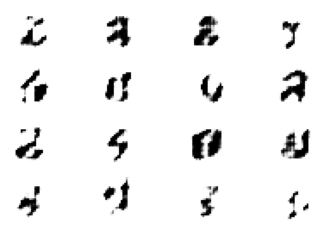



epoch -> [2/200], discriminator_loss_for_real_data = 312.67, discriminator_loss_for_fake_data = 316.75, generator_loss = 366.14



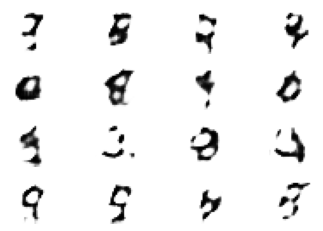



epoch -> [3/200], discriminator_loss_for_real_data = 306.94, discriminator_loss_for_fake_data = 307.27, generator_loss = 374.42



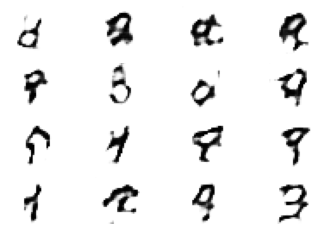



epoch -> [4/200], discriminator_loss_for_real_data = 312.84, discriminator_loss_for_fake_data = 316.10, generator_loss = 362.39



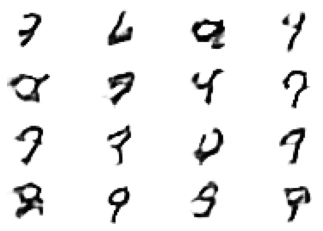



epoch -> [5/200], discriminator_loss_for_real_data = 318.22, discriminator_loss_for_fake_data = 320.14, generator_loss = 351.40



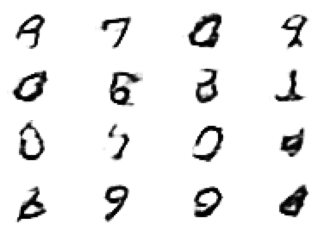



epoch -> [6/200], discriminator_loss_for_real_data = 316.08, discriminator_loss_for_fake_data = 318.37, generator_loss = 352.70



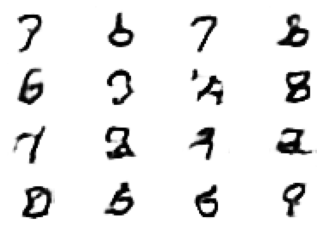



epoch -> [7/200], discriminator_loss_for_real_data = 312.86, discriminator_loss_for_fake_data = 317.03, generator_loss = 358.16



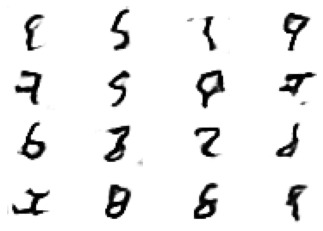



epoch -> [8/200], discriminator_loss_for_real_data = 310.64, discriminator_loss_for_fake_data = 314.79, generator_loss = 364.06



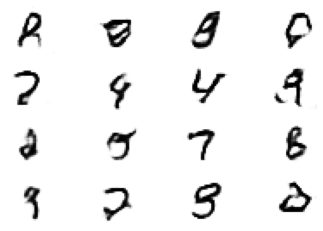



epoch -> [9/200], discriminator_loss_for_real_data = 310.69, discriminator_loss_for_fake_data = 313.79, generator_loss = 367.70



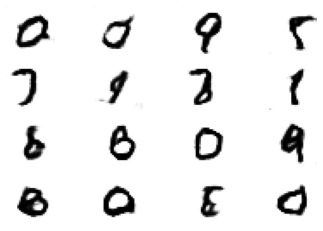



epoch -> [10/200], discriminator_loss_for_real_data = 310.71, discriminator_loss_for_fake_data = 313.97, generator_loss = 367.09



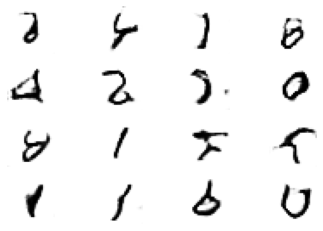



epoch -> [11/200], discriminator_loss_for_real_data = 312.23, discriminator_loss_for_fake_data = 315.23, generator_loss = 364.88



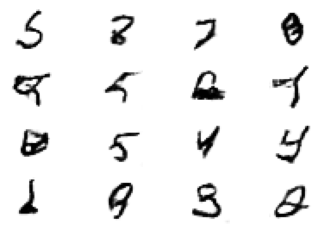



epoch -> [12/200], discriminator_loss_for_real_data = 313.28, discriminator_loss_for_fake_data = 316.08, generator_loss = 363.10



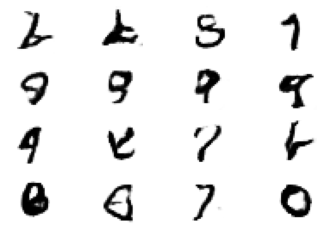



epoch -> [13/200], discriminator_loss_for_real_data = 315.23, discriminator_loss_for_fake_data = 316.97, generator_loss = 358.69



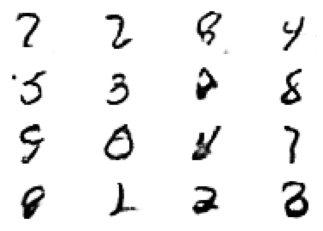



epoch -> [14/200], discriminator_loss_for_real_data = 315.91, discriminator_loss_for_fake_data = 317.92, generator_loss = 356.62



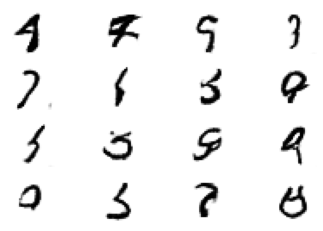



epoch -> [15/200], discriminator_loss_for_real_data = 316.78, discriminator_loss_for_fake_data = 319.01, generator_loss = 354.71



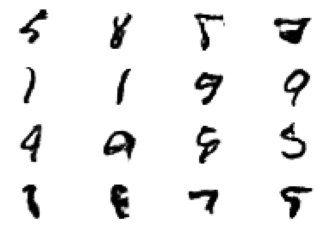



epoch -> [16/200], discriminator_loss_for_real_data = 317.23, discriminator_loss_for_fake_data = 319.46, generator_loss = 352.19



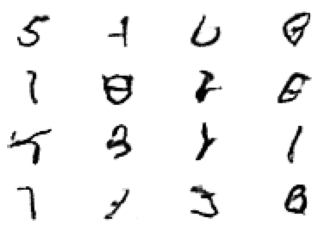



epoch -> [17/200], discriminator_loss_for_real_data = 317.39, discriminator_loss_for_fake_data = 319.74, generator_loss = 349.85



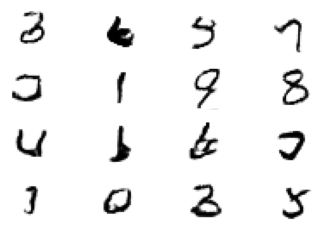



epoch -> [18/200], discriminator_loss_for_real_data = 318.24, discriminator_loss_for_fake_data = 319.84, generator_loss = 349.03



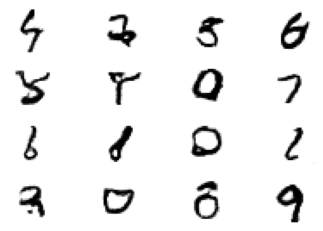



epoch -> [19/200], discriminator_loss_for_real_data = 318.86, discriminator_loss_for_fake_data = 320.22, generator_loss = 347.63



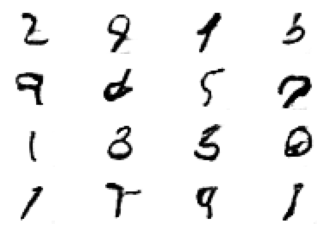



epoch -> [20/200], discriminator_loss_for_real_data = 318.49, discriminator_loss_for_fake_data = 320.77, generator_loss = 346.29



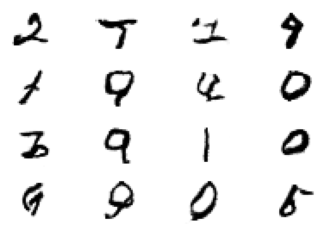



epoch -> [21/200], discriminator_loss_for_real_data = 319.36, discriminator_loss_for_fake_data = 320.13, generator_loss = 346.83



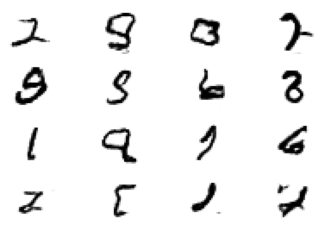



epoch -> [22/200], discriminator_loss_for_real_data = 318.40, discriminator_loss_for_fake_data = 320.95, generator_loss = 344.93



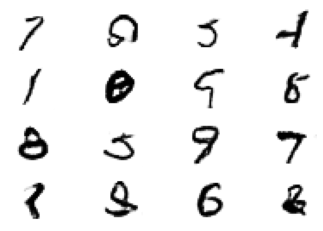



epoch -> [23/200], discriminator_loss_for_real_data = 318.55, discriminator_loss_for_fake_data = 320.64, generator_loss = 345.06



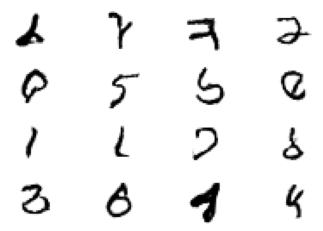



epoch -> [24/200], discriminator_loss_for_real_data = 318.59, discriminator_loss_for_fake_data = 320.83, generator_loss = 344.33



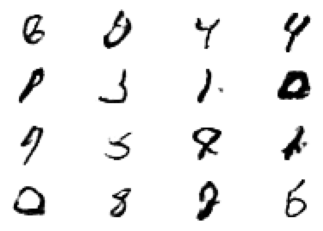



epoch -> [25/200], discriminator_loss_for_real_data = 318.99, discriminator_loss_for_fake_data = 320.71, generator_loss = 344.68



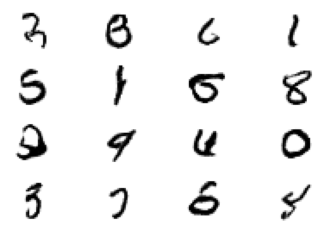



epoch -> [26/200], discriminator_loss_for_real_data = 318.91, discriminator_loss_for_fake_data = 320.64, generator_loss = 344.19



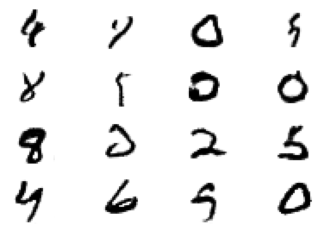



epoch -> [27/200], discriminator_loss_for_real_data = 319.07, discriminator_loss_for_fake_data = 319.99, generator_loss = 344.34



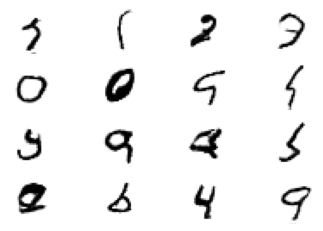



epoch -> [28/200], discriminator_loss_for_real_data = 318.26, discriminator_loss_for_fake_data = 320.62, generator_loss = 344.19



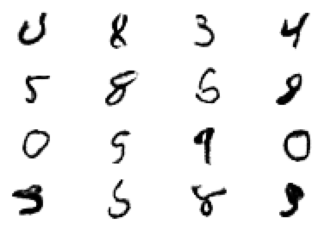



epoch -> [29/200], discriminator_loss_for_real_data = 318.18, discriminator_loss_for_fake_data = 320.70, generator_loss = 343.69



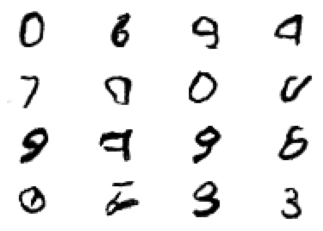



epoch -> [30/200], discriminator_loss_for_real_data = 318.66, discriminator_loss_for_fake_data = 320.23, generator_loss = 344.35



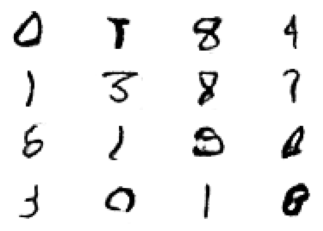



epoch -> [31/200], discriminator_loss_for_real_data = 318.26, discriminator_loss_for_fake_data = 320.06, generator_loss = 344.66



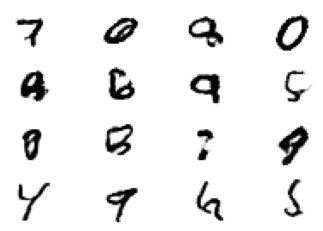



epoch -> [32/200], discriminator_loss_for_real_data = 317.55, discriminator_loss_for_fake_data = 319.85, generator_loss = 345.58



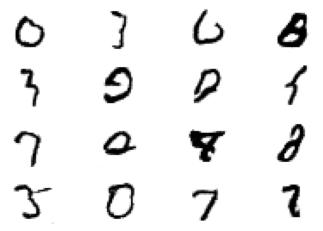



epoch -> [33/200], discriminator_loss_for_real_data = 318.01, discriminator_loss_for_fake_data = 320.01, generator_loss = 345.43



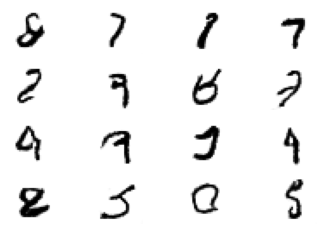



epoch -> [34/200], discriminator_loss_for_real_data = 318.13, discriminator_loss_for_fake_data = 319.73, generator_loss = 344.93



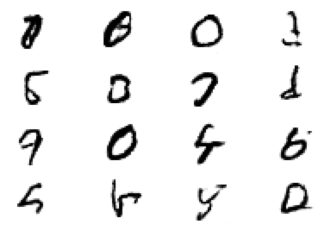



epoch -> [35/200], discriminator_loss_for_real_data = 317.95, discriminator_loss_for_fake_data = 319.48, generator_loss = 345.62



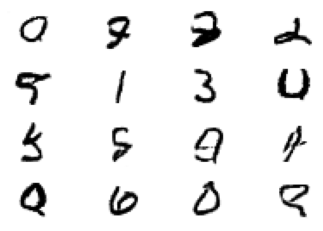



epoch -> [36/200], discriminator_loss_for_real_data = 318.20, discriminator_loss_for_fake_data = 319.21, generator_loss = 345.77



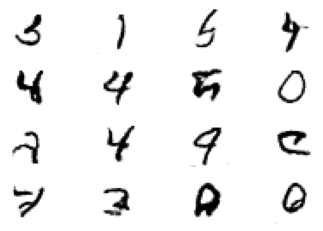



epoch -> [37/200], discriminator_loss_for_real_data = 317.08, discriminator_loss_for_fake_data = 319.24, generator_loss = 345.95



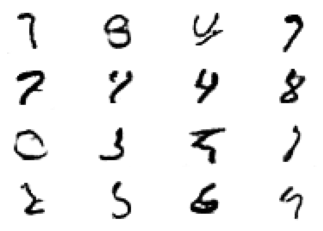



epoch -> [38/200], discriminator_loss_for_real_data = 317.16, discriminator_loss_for_fake_data = 319.09, generator_loss = 347.19



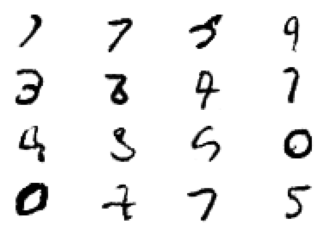



epoch -> [39/200], discriminator_loss_for_real_data = 317.97, discriminator_loss_for_fake_data = 319.27, generator_loss = 346.20



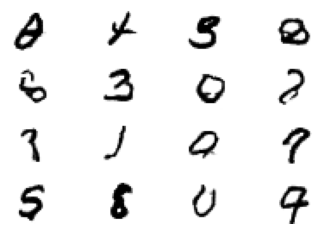



epoch -> [40/200], discriminator_loss_for_real_data = 317.29, discriminator_loss_for_fake_data = 319.30, generator_loss = 346.79



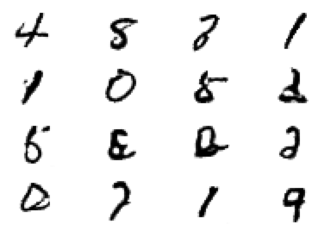



epoch -> [41/200], discriminator_loss_for_real_data = 316.53, discriminator_loss_for_fake_data = 319.39, generator_loss = 346.65



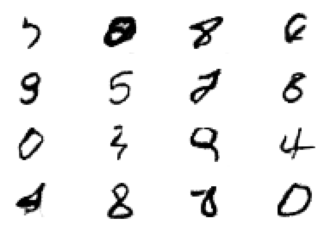



epoch -> [42/200], discriminator_loss_for_real_data = 317.14, discriminator_loss_for_fake_data = 318.47, generator_loss = 347.27



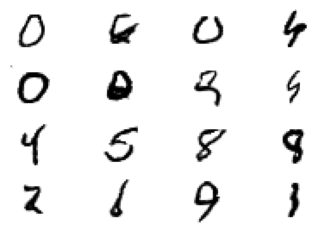



epoch -> [43/200], discriminator_loss_for_real_data = 316.90, discriminator_loss_for_fake_data = 318.52, generator_loss = 346.93



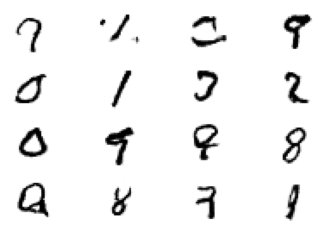



epoch -> [44/200], discriminator_loss_for_real_data = 316.65, discriminator_loss_for_fake_data = 318.12, generator_loss = 348.07



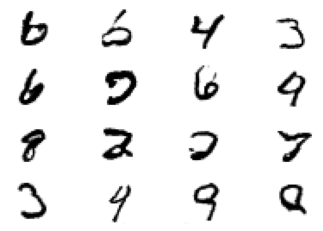



epoch -> [45/200], discriminator_loss_for_real_data = 316.36, discriminator_loss_for_fake_data = 318.53, generator_loss = 348.60



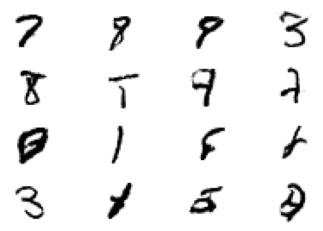



epoch -> [46/200], discriminator_loss_for_real_data = 316.81, discriminator_loss_for_fake_data = 317.68, generator_loss = 349.59



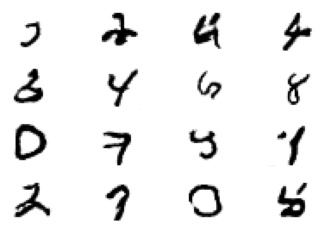



epoch -> [47/200], discriminator_loss_for_real_data = 316.49, discriminator_loss_for_fake_data = 317.76, generator_loss = 349.44



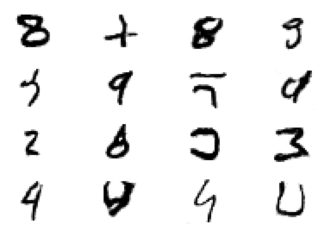



epoch -> [48/200], discriminator_loss_for_real_data = 316.24, discriminator_loss_for_fake_data = 318.08, generator_loss = 350.38



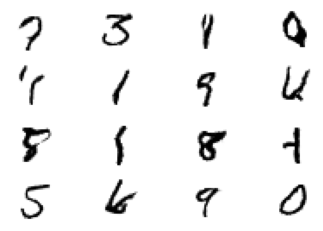



epoch -> [49/200], discriminator_loss_for_real_data = 315.98, discriminator_loss_for_fake_data = 317.20, generator_loss = 350.09



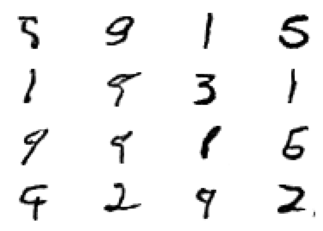



epoch -> [50/200], discriminator_loss_for_real_data = 316.09, discriminator_loss_for_fake_data = 317.87, generator_loss = 349.61



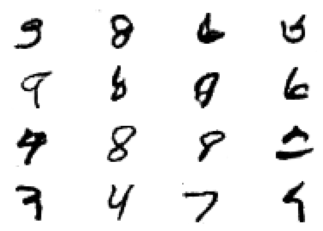



epoch -> [51/200], discriminator_loss_for_real_data = 315.64, discriminator_loss_for_fake_data = 317.02, generator_loss = 351.24



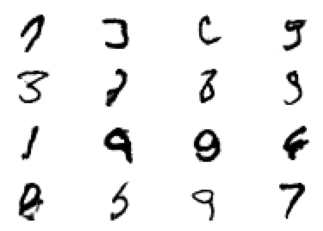



epoch -> [52/200], discriminator_loss_for_real_data = 315.92, discriminator_loss_for_fake_data = 317.04, generator_loss = 351.06



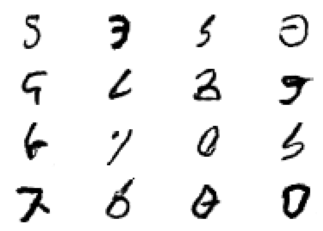



epoch -> [53/200], discriminator_loss_for_real_data = 315.59, discriminator_loss_for_fake_data = 317.48, generator_loss = 351.05



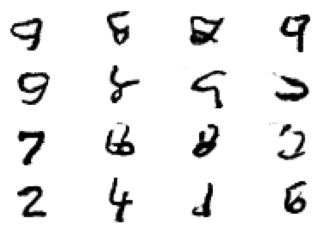



epoch -> [54/200], discriminator_loss_for_real_data = 315.14, discriminator_loss_for_fake_data = 316.50, generator_loss = 352.79



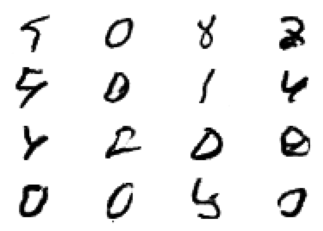



epoch -> [55/200], discriminator_loss_for_real_data = 315.76, discriminator_loss_for_fake_data = 317.31, generator_loss = 352.06



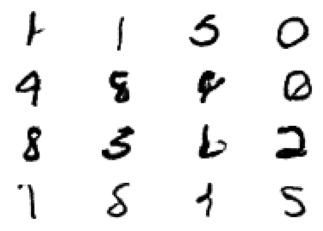



epoch -> [56/200], discriminator_loss_for_real_data = 315.06, discriminator_loss_for_fake_data = 316.91, generator_loss = 352.30



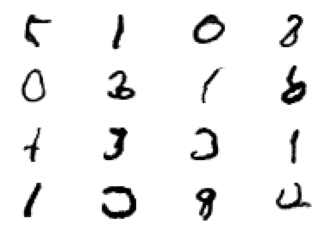



epoch -> [57/200], discriminator_loss_for_real_data = 314.25, discriminator_loss_for_fake_data = 316.52, generator_loss = 353.82



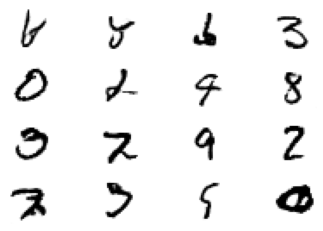



epoch -> [58/200], discriminator_loss_for_real_data = 314.35, discriminator_loss_for_fake_data = 315.81, generator_loss = 354.77



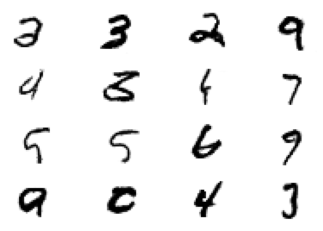



epoch -> [59/200], discriminator_loss_for_real_data = 314.82, discriminator_loss_for_fake_data = 316.03, generator_loss = 354.38



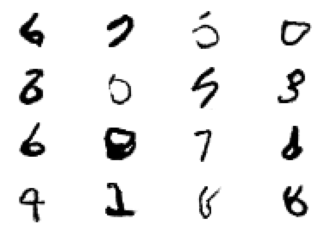



epoch -> [60/200], discriminator_loss_for_real_data = 314.59, discriminator_loss_for_fake_data = 314.86, generator_loss = 356.10



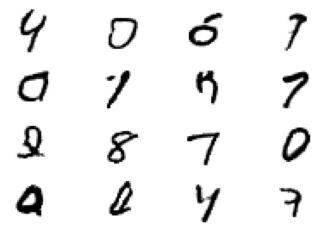



epoch -> [61/200], discriminator_loss_for_real_data = 314.14, discriminator_loss_for_fake_data = 315.56, generator_loss = 355.67



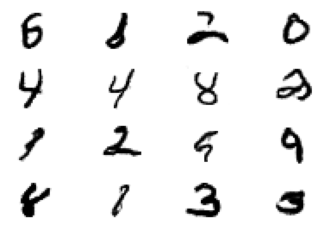



epoch -> [62/200], discriminator_loss_for_real_data = 314.29, discriminator_loss_for_fake_data = 315.71, generator_loss = 355.49



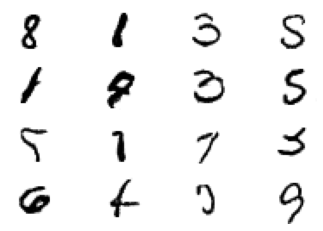



epoch -> [63/200], discriminator_loss_for_real_data = 314.28, discriminator_loss_for_fake_data = 315.54, generator_loss = 356.11



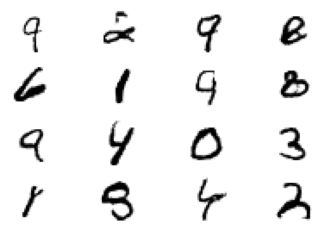



epoch -> [64/200], discriminator_loss_for_real_data = 314.66, discriminator_loss_for_fake_data = 314.81, generator_loss = 356.82



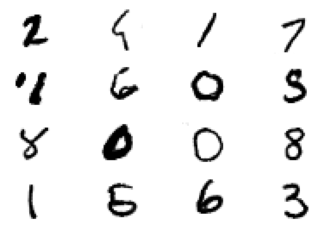



epoch -> [65/200], discriminator_loss_for_real_data = 313.15, discriminator_loss_for_fake_data = 314.87, generator_loss = 357.19



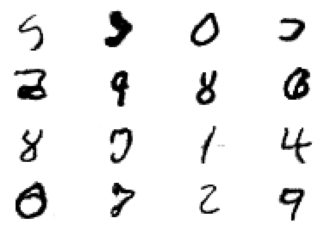



epoch -> [66/200], discriminator_loss_for_real_data = 313.93, discriminator_loss_for_fake_data = 314.07, generator_loss = 357.87



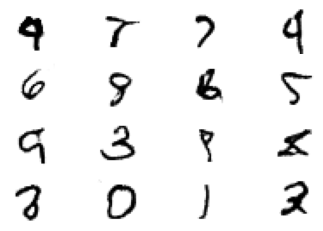



epoch -> [67/200], discriminator_loss_for_real_data = 312.64, discriminator_loss_for_fake_data = 314.30, generator_loss = 359.27



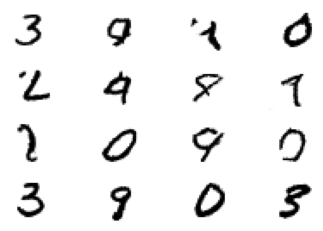



epoch -> [68/200], discriminator_loss_for_real_data = 312.54, discriminator_loss_for_fake_data = 314.02, generator_loss = 359.08



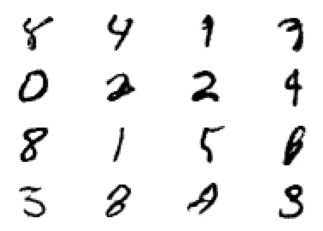



epoch -> [69/200], discriminator_loss_for_real_data = 313.56, discriminator_loss_for_fake_data = 314.46, generator_loss = 359.81



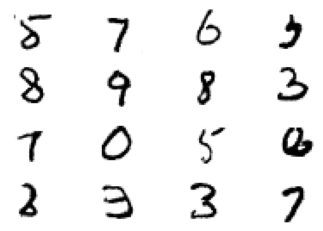



epoch -> [70/200], discriminator_loss_for_real_data = 313.49, discriminator_loss_for_fake_data = 314.18, generator_loss = 359.92



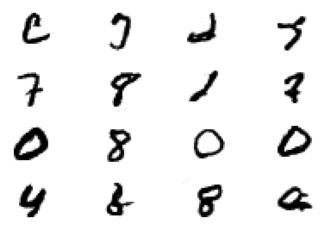



epoch -> [71/200], discriminator_loss_for_real_data = 312.54, discriminator_loss_for_fake_data = 314.43, generator_loss = 359.65



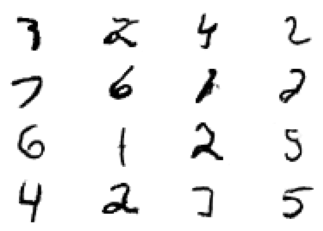



epoch -> [72/200], discriminator_loss_for_real_data = 312.42, discriminator_loss_for_fake_data = 314.80, generator_loss = 360.85



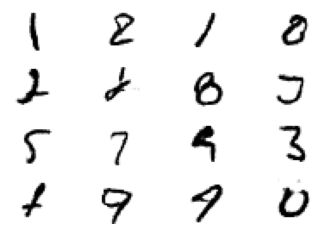



epoch -> [73/200], discriminator_loss_for_real_data = 311.76, discriminator_loss_for_fake_data = 313.17, generator_loss = 363.20



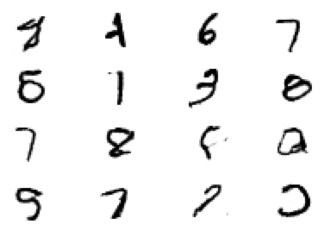



epoch -> [74/200], discriminator_loss_for_real_data = 312.40, discriminator_loss_for_fake_data = 313.24, generator_loss = 362.86



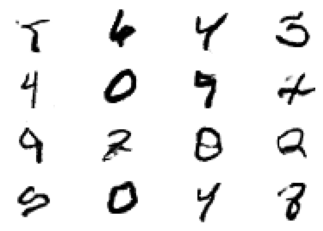



epoch -> [75/200], discriminator_loss_for_real_data = 311.67, discriminator_loss_for_fake_data = 312.76, generator_loss = 362.34



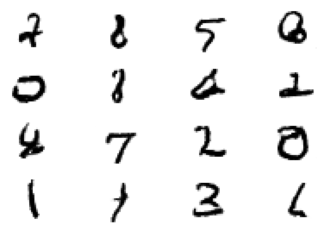



epoch -> [76/200], discriminator_loss_for_real_data = 312.00, discriminator_loss_for_fake_data = 312.72, generator_loss = 363.63



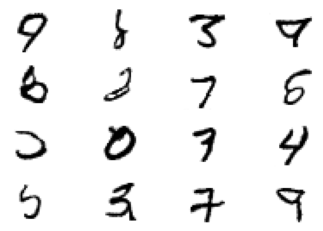



epoch -> [77/200], discriminator_loss_for_real_data = 311.95, discriminator_loss_for_fake_data = 312.12, generator_loss = 364.51



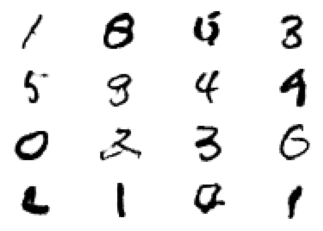



epoch -> [78/200], discriminator_loss_for_real_data = 311.80, discriminator_loss_for_fake_data = 312.48, generator_loss = 363.89



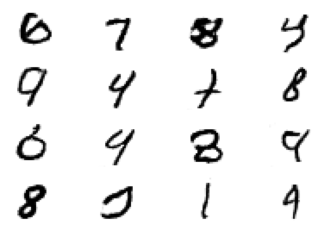



epoch -> [79/200], discriminator_loss_for_real_data = 310.94, discriminator_loss_for_fake_data = 311.90, generator_loss = 365.96



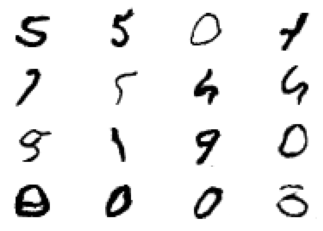



epoch -> [80/200], discriminator_loss_for_real_data = 310.89, discriminator_loss_for_fake_data = 311.76, generator_loss = 366.21



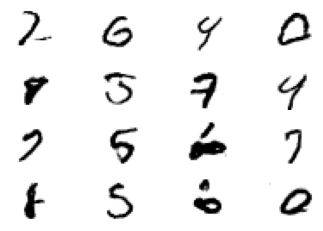



epoch -> [81/200], discriminator_loss_for_real_data = 310.74, discriminator_loss_for_fake_data = 311.19, generator_loss = 367.06



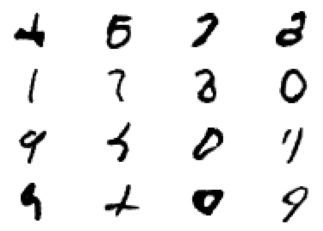



epoch -> [82/200], discriminator_loss_for_real_data = 310.35, discriminator_loss_for_fake_data = 312.09, generator_loss = 366.47



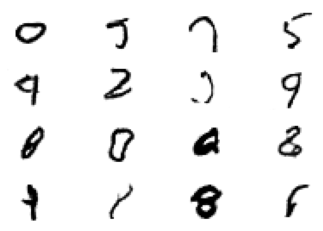



epoch -> [83/200], discriminator_loss_for_real_data = 309.44, discriminator_loss_for_fake_data = 310.45, generator_loss = 368.23



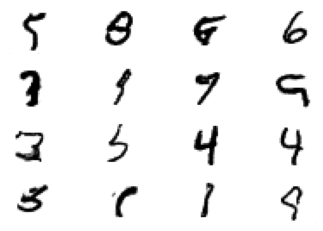



epoch -> [84/200], discriminator_loss_for_real_data = 310.06, discriminator_loss_for_fake_data = 310.43, generator_loss = 368.84



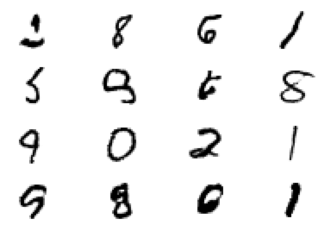



epoch -> [85/200], discriminator_loss_for_real_data = 309.95, discriminator_loss_for_fake_data = 310.77, generator_loss = 369.02



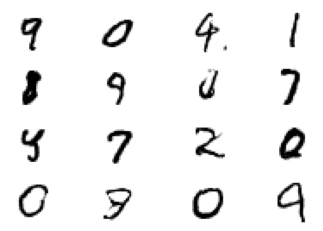



epoch -> [86/200], discriminator_loss_for_real_data = 309.22, discriminator_loss_for_fake_data = 309.80, generator_loss = 370.49



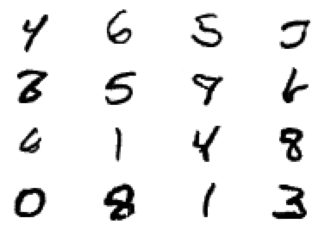



epoch -> [87/200], discriminator_loss_for_real_data = 308.65, discriminator_loss_for_fake_data = 309.74, generator_loss = 371.17



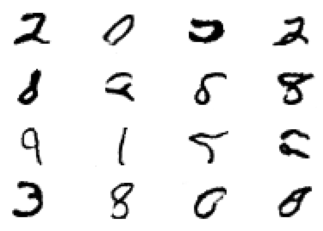



epoch -> [88/200], discriminator_loss_for_real_data = 308.84, discriminator_loss_for_fake_data = 308.92, generator_loss = 374.46



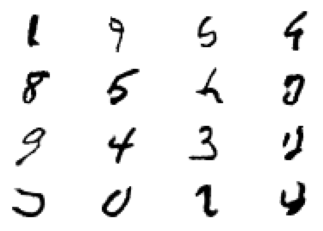



epoch -> [89/200], discriminator_loss_for_real_data = 308.50, discriminator_loss_for_fake_data = 308.63, generator_loss = 374.15



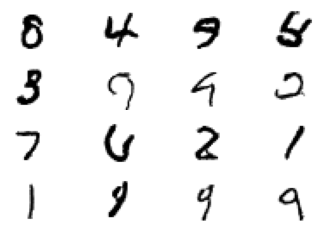



epoch -> [90/200], discriminator_loss_for_real_data = 307.33, discriminator_loss_for_fake_data = 307.71, generator_loss = 374.32



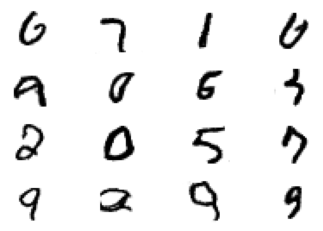



epoch -> [91/200], discriminator_loss_for_real_data = 307.80, discriminator_loss_for_fake_data = 307.82, generator_loss = 376.37



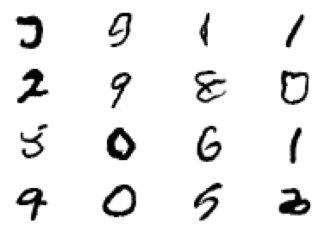



epoch -> [92/200], discriminator_loss_for_real_data = 307.75, discriminator_loss_for_fake_data = 306.36, generator_loss = 377.16



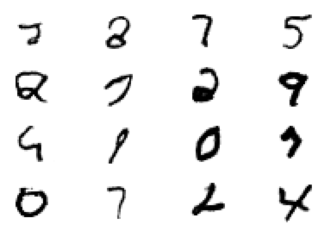



epoch -> [93/200], discriminator_loss_for_real_data = 306.05, discriminator_loss_for_fake_data = 306.78, generator_loss = 378.13



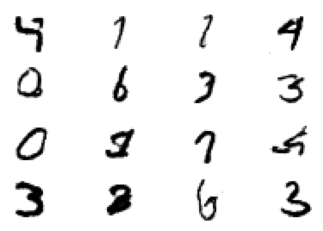



epoch -> [94/200], discriminator_loss_for_real_data = 307.50, discriminator_loss_for_fake_data = 305.93, generator_loss = 380.45



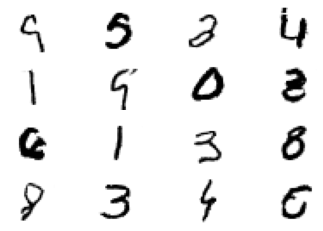



epoch -> [95/200], discriminator_loss_for_real_data = 306.47, discriminator_loss_for_fake_data = 306.23, generator_loss = 379.90



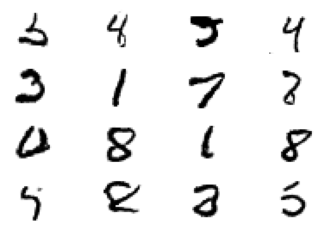



epoch -> [96/200], discriminator_loss_for_real_data = 305.36, discriminator_loss_for_fake_data = 304.53, generator_loss = 383.76



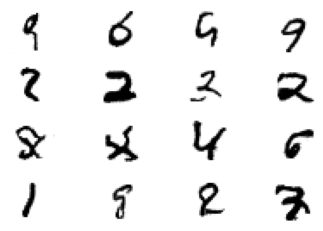



epoch -> [97/200], discriminator_loss_for_real_data = 304.24, discriminator_loss_for_fake_data = 303.68, generator_loss = 382.99



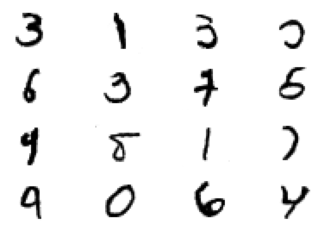



epoch -> [98/200], discriminator_loss_for_real_data = 303.80, discriminator_loss_for_fake_data = 303.58, generator_loss = 385.35



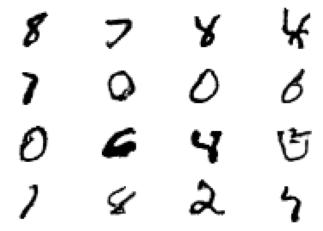



epoch -> [99/200], discriminator_loss_for_real_data = 303.72, discriminator_loss_for_fake_data = 303.05, generator_loss = 387.27



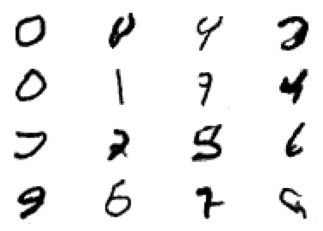



epoch -> [100/200], discriminator_loss_for_real_data = 302.49, discriminator_loss_for_fake_data = 302.50, generator_loss = 387.68



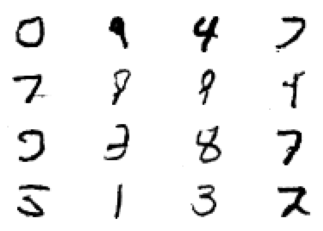



epoch -> [101/200], discriminator_loss_for_real_data = 302.35, discriminator_loss_for_fake_data = 302.36, generator_loss = 388.54



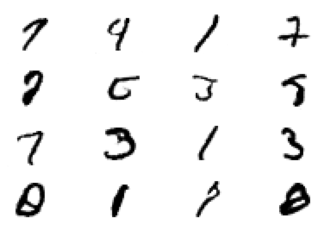



epoch -> [102/200], discriminator_loss_for_real_data = 301.40, discriminator_loss_for_fake_data = 301.42, generator_loss = 390.24



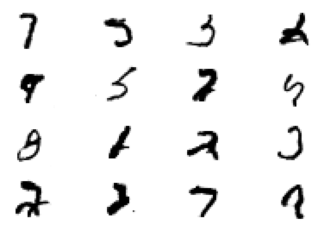



epoch -> [103/200], discriminator_loss_for_real_data = 300.64, discriminator_loss_for_fake_data = 299.82, generator_loss = 393.50



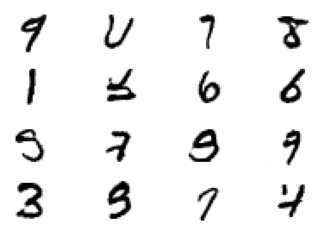



epoch -> [104/200], discriminator_loss_for_real_data = 300.39, discriminator_loss_for_fake_data = 300.10, generator_loss = 394.76



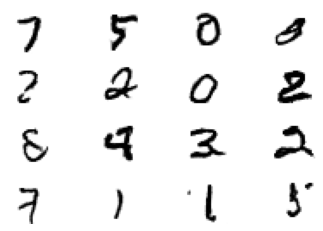



epoch -> [105/200], discriminator_loss_for_real_data = 299.26, discriminator_loss_for_fake_data = 298.27, generator_loss = 396.81



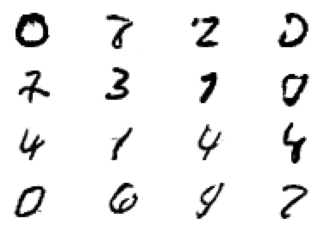



epoch -> [106/200], discriminator_loss_for_real_data = 298.57, discriminator_loss_for_fake_data = 296.98, generator_loss = 400.00



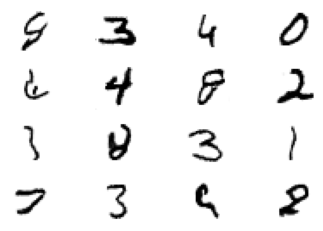



epoch -> [107/200], discriminator_loss_for_real_data = 297.55, discriminator_loss_for_fake_data = 296.25, generator_loss = 401.96



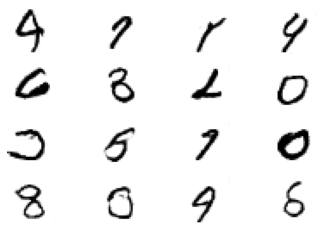



epoch -> [108/200], discriminator_loss_for_real_data = 296.42, discriminator_loss_for_fake_data = 294.63, generator_loss = 405.33



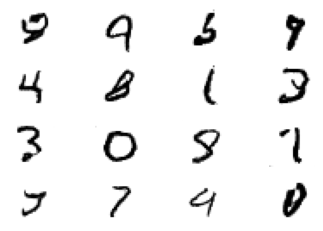



epoch -> [109/200], discriminator_loss_for_real_data = 295.89, discriminator_loss_for_fake_data = 294.50, generator_loss = 405.40



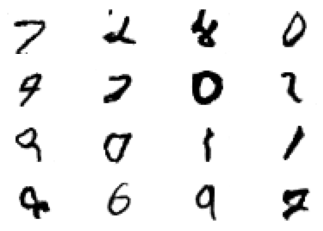



epoch -> [110/200], discriminator_loss_for_real_data = 295.10, discriminator_loss_for_fake_data = 293.33, generator_loss = 408.86



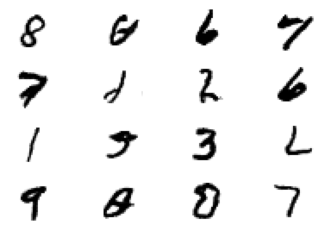



epoch -> [111/200], discriminator_loss_for_real_data = 293.78, discriminator_loss_for_fake_data = 291.39, generator_loss = 411.70



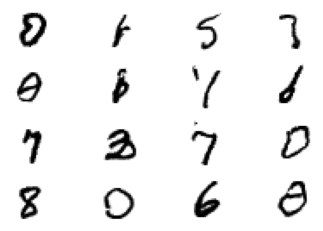



epoch -> [112/200], discriminator_loss_for_real_data = 293.87, discriminator_loss_for_fake_data = 291.52, generator_loss = 410.98



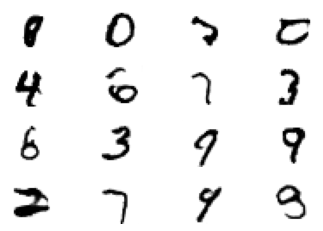



epoch -> [113/200], discriminator_loss_for_real_data = 293.43, discriminator_loss_for_fake_data = 290.07, generator_loss = 416.50



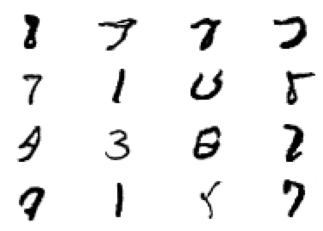



epoch -> [114/200], discriminator_loss_for_real_data = 291.46, discriminator_loss_for_fake_data = 290.12, generator_loss = 416.17



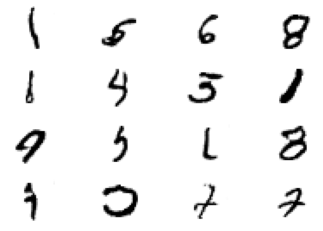



epoch -> [115/200], discriminator_loss_for_real_data = 291.80, discriminator_loss_for_fake_data = 289.23, generator_loss = 418.81



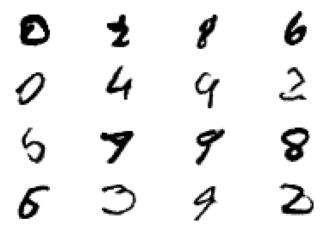



epoch -> [116/200], discriminator_loss_for_real_data = 291.04, discriminator_loss_for_fake_data = 288.56, generator_loss = 421.41



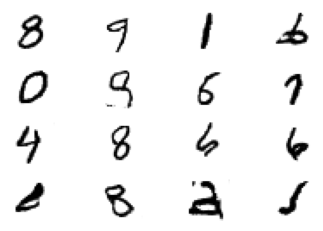



epoch -> [117/200], discriminator_loss_for_real_data = 289.06, discriminator_loss_for_fake_data = 286.11, generator_loss = 425.10



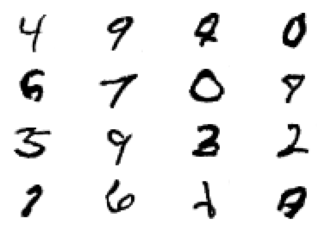



epoch -> [118/200], discriminator_loss_for_real_data = 288.60, discriminator_loss_for_fake_data = 284.92, generator_loss = 426.09



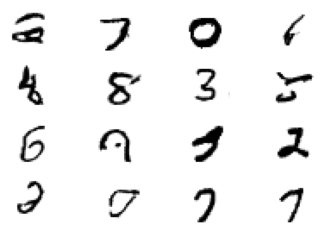



epoch -> [119/200], discriminator_loss_for_real_data = 287.46, discriminator_loss_for_fake_data = 284.10, generator_loss = 430.81



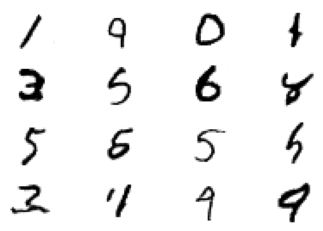



epoch -> [120/200], discriminator_loss_for_real_data = 287.93, discriminator_loss_for_fake_data = 283.24, generator_loss = 430.63



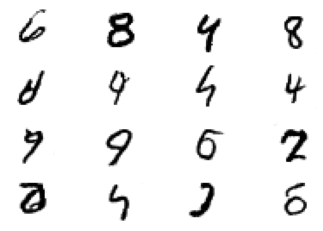



epoch -> [121/200], discriminator_loss_for_real_data = 286.68, discriminator_loss_for_fake_data = 281.88, generator_loss = 437.64



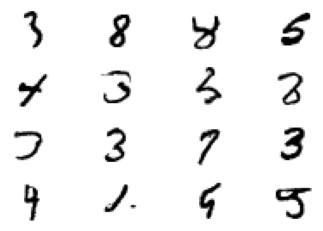



epoch -> [122/200], discriminator_loss_for_real_data = 285.60, discriminator_loss_for_fake_data = 282.01, generator_loss = 436.48



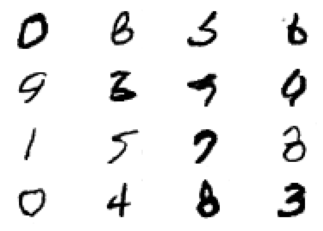



epoch -> [123/200], discriminator_loss_for_real_data = 283.92, discriminator_loss_for_fake_data = 279.42, generator_loss = 439.36



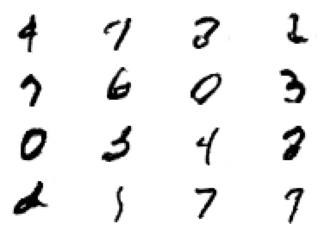



epoch -> [124/200], discriminator_loss_for_real_data = 284.02, discriminator_loss_for_fake_data = 279.82, generator_loss = 442.45



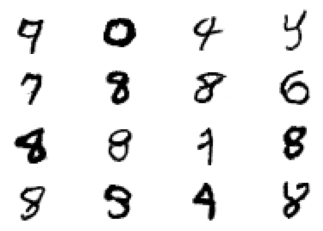



epoch -> [125/200], discriminator_loss_for_real_data = 284.98, discriminator_loss_for_fake_data = 278.03, generator_loss = 443.06



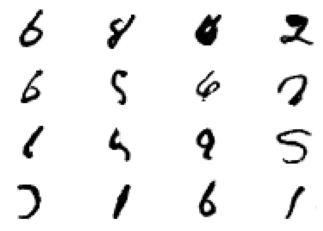



epoch -> [126/200], discriminator_loss_for_real_data = 282.46, discriminator_loss_for_fake_data = 278.19, generator_loss = 447.45



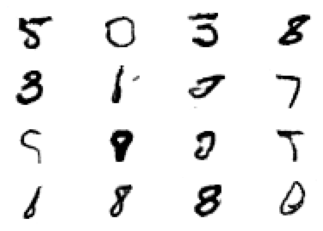



epoch -> [127/200], discriminator_loss_for_real_data = 281.05, discriminator_loss_for_fake_data = 276.13, generator_loss = 450.64



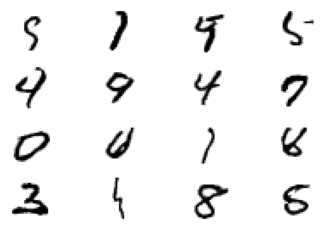



epoch -> [128/200], discriminator_loss_for_real_data = 281.05, discriminator_loss_for_fake_data = 275.95, generator_loss = 451.86



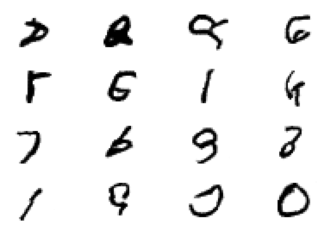



epoch -> [129/200], discriminator_loss_for_real_data = 279.41, discriminator_loss_for_fake_data = 272.77, generator_loss = 456.36



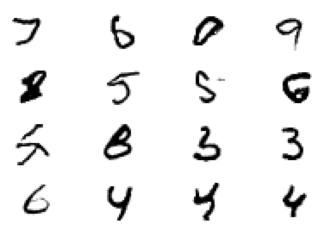



epoch -> [130/200], discriminator_loss_for_real_data = 278.95, discriminator_loss_for_fake_data = 273.77, generator_loss = 454.59



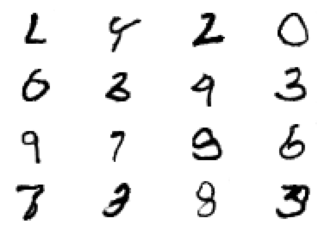



epoch -> [131/200], discriminator_loss_for_real_data = 279.47, discriminator_loss_for_fake_data = 272.96, generator_loss = 458.72



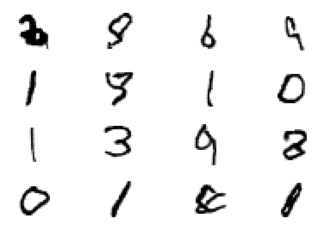



epoch -> [132/200], discriminator_loss_for_real_data = 277.60, discriminator_loss_for_fake_data = 271.71, generator_loss = 462.94



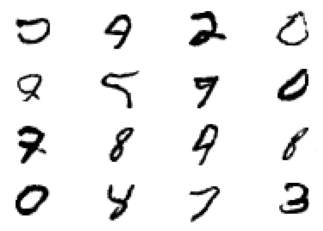



epoch -> [133/200], discriminator_loss_for_real_data = 277.66, discriminator_loss_for_fake_data = 270.93, generator_loss = 464.11



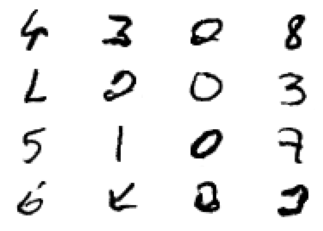



epoch -> [134/200], discriminator_loss_for_real_data = 276.23, discriminator_loss_for_fake_data = 269.46, generator_loss = 465.82



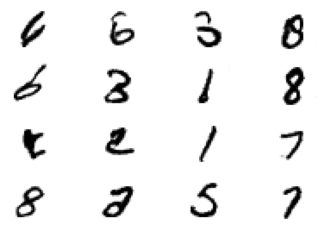



epoch -> [135/200], discriminator_loss_for_real_data = 275.84, discriminator_loss_for_fake_data = 268.38, generator_loss = 469.33



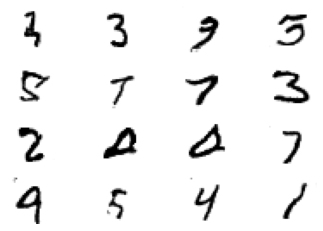



epoch -> [136/200], discriminator_loss_for_real_data = 275.31, discriminator_loss_for_fake_data = 267.28, generator_loss = 471.52



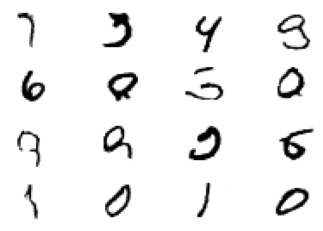



epoch -> [137/200], discriminator_loss_for_real_data = 272.66, discriminator_loss_for_fake_data = 265.15, generator_loss = 477.25



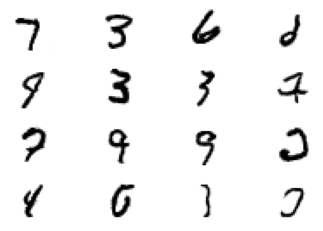



epoch -> [138/200], discriminator_loss_for_real_data = 274.20, discriminator_loss_for_fake_data = 266.62, generator_loss = 475.69



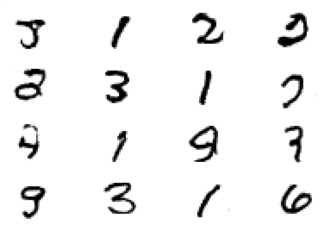



epoch -> [139/200], discriminator_loss_for_real_data = 273.19, discriminator_loss_for_fake_data = 265.34, generator_loss = 477.73



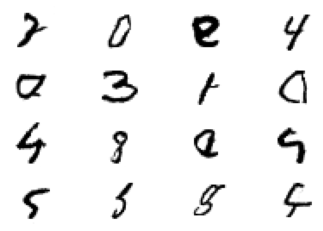



epoch -> [140/200], discriminator_loss_for_real_data = 274.24, discriminator_loss_for_fake_data = 266.52, generator_loss = 476.80



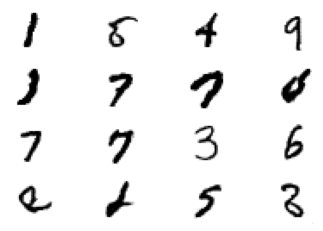



epoch -> [141/200], discriminator_loss_for_real_data = 272.94, discriminator_loss_for_fake_data = 263.61, generator_loss = 481.09



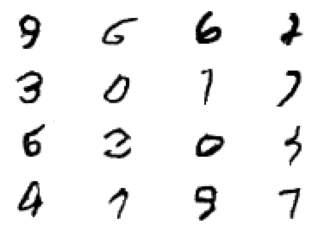



epoch -> [142/200], discriminator_loss_for_real_data = 270.97, discriminator_loss_for_fake_data = 262.82, generator_loss = 482.23



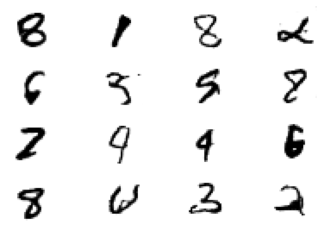



epoch -> [143/200], discriminator_loss_for_real_data = 270.45, discriminator_loss_for_fake_data = 261.76, generator_loss = 489.28



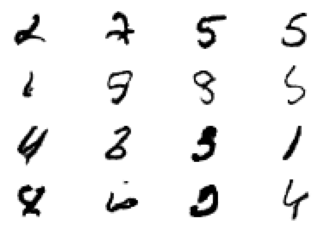



epoch -> [144/200], discriminator_loss_for_real_data = 269.26, discriminator_loss_for_fake_data = 260.57, generator_loss = 491.46



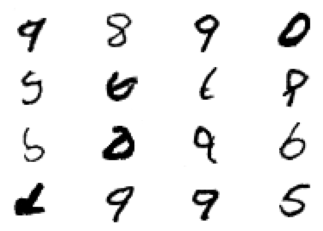



epoch -> [145/200], discriminator_loss_for_real_data = 270.28, discriminator_loss_for_fake_data = 260.83, generator_loss = 495.13



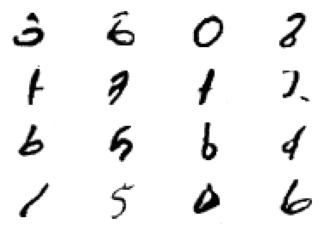



epoch -> [146/200], discriminator_loss_for_real_data = 267.10, discriminator_loss_for_fake_data = 258.34, generator_loss = 498.31



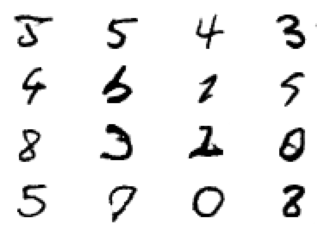



epoch -> [147/200], discriminator_loss_for_real_data = 268.21, discriminator_loss_for_fake_data = 257.29, generator_loss = 501.95



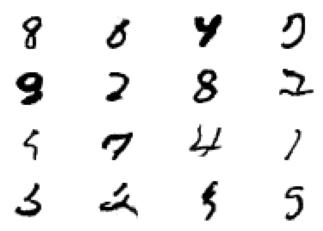



epoch -> [148/200], discriminator_loss_for_real_data = 266.08, discriminator_loss_for_fake_data = 256.07, generator_loss = 503.12



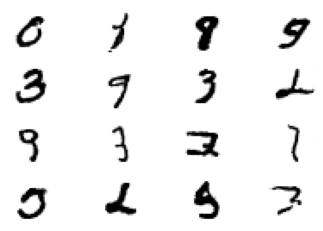



epoch -> [149/200], discriminator_loss_for_real_data = 266.62, discriminator_loss_for_fake_data = 255.97, generator_loss = 503.66



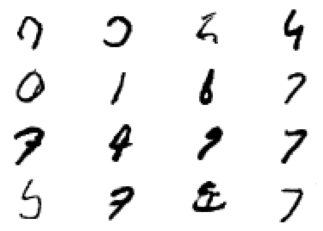



epoch -> [150/200], discriminator_loss_for_real_data = 265.30, discriminator_loss_for_fake_data = 256.10, generator_loss = 507.93



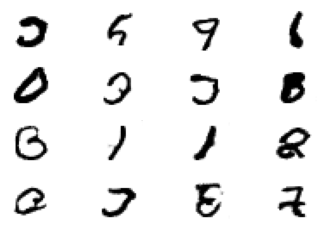



epoch -> [151/200], discriminator_loss_for_real_data = 265.46, discriminator_loss_for_fake_data = 255.38, generator_loss = 508.44



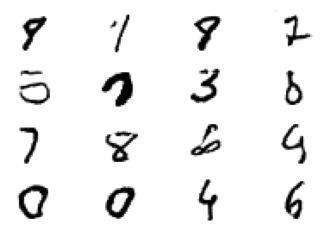



epoch -> [152/200], discriminator_loss_for_real_data = 262.66, discriminator_loss_for_fake_data = 252.94, generator_loss = 513.10



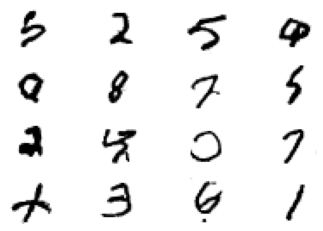



epoch -> [153/200], discriminator_loss_for_real_data = 265.07, discriminator_loss_for_fake_data = 254.81, generator_loss = 511.79



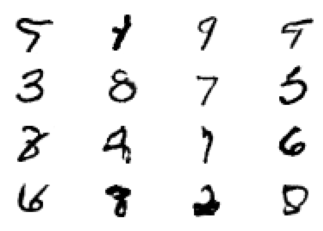



epoch -> [154/200], discriminator_loss_for_real_data = 263.45, discriminator_loss_for_fake_data = 253.03, generator_loss = 515.42



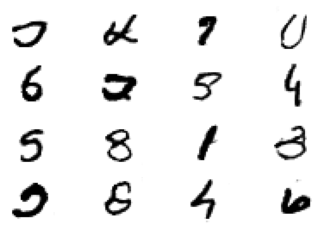



epoch -> [155/200], discriminator_loss_for_real_data = 263.55, discriminator_loss_for_fake_data = 252.31, generator_loss = 519.37



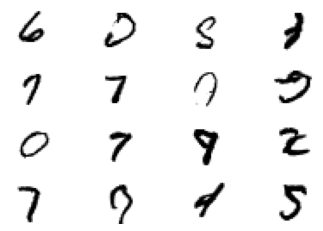



epoch -> [156/200], discriminator_loss_for_real_data = 260.77, discriminator_loss_for_fake_data = 249.75, generator_loss = 520.39



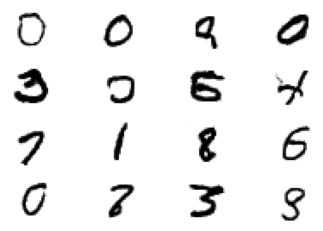



epoch -> [157/200], discriminator_loss_for_real_data = 261.50, discriminator_loss_for_fake_data = 250.83, generator_loss = 518.73



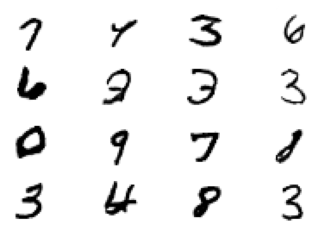



epoch -> [158/200], discriminator_loss_for_real_data = 260.98, discriminator_loss_for_fake_data = 247.55, generator_loss = 528.29



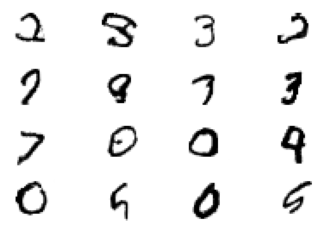



epoch -> [159/200], discriminator_loss_for_real_data = 260.54, discriminator_loss_for_fake_data = 250.22, generator_loss = 526.55



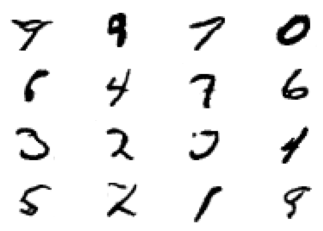



epoch -> [160/200], discriminator_loss_for_real_data = 260.39, discriminator_loss_for_fake_data = 246.79, generator_loss = 531.05



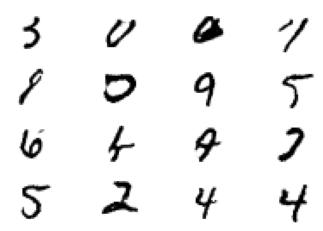



epoch -> [161/200], discriminator_loss_for_real_data = 259.44, discriminator_loss_for_fake_data = 246.63, generator_loss = 530.18



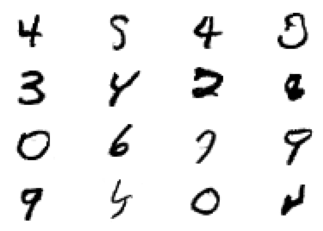



epoch -> [162/200], discriminator_loss_for_real_data = 258.59, discriminator_loss_for_fake_data = 246.36, generator_loss = 535.54



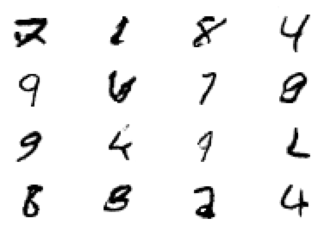



epoch -> [163/200], discriminator_loss_for_real_data = 256.91, discriminator_loss_for_fake_data = 244.16, generator_loss = 538.29



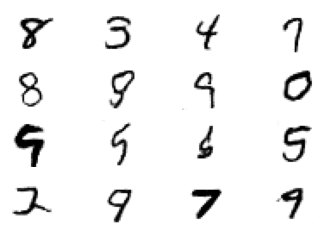



epoch -> [164/200], discriminator_loss_for_real_data = 256.45, discriminator_loss_for_fake_data = 244.14, generator_loss = 540.06



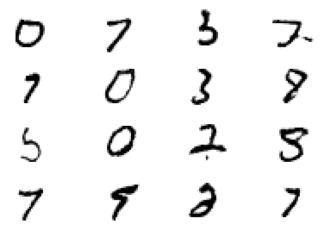



epoch -> [165/200], discriminator_loss_for_real_data = 255.81, discriminator_loss_for_fake_data = 242.95, generator_loss = 542.50



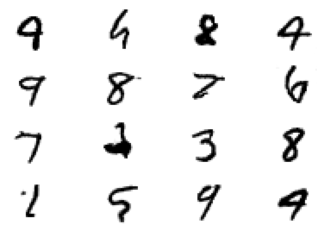



epoch -> [166/200], discriminator_loss_for_real_data = 256.22, discriminator_loss_for_fake_data = 243.40, generator_loss = 540.28



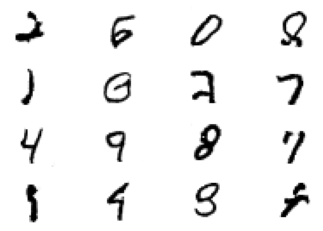



epoch -> [167/200], discriminator_loss_for_real_data = 255.66, discriminator_loss_for_fake_data = 242.66, generator_loss = 544.55



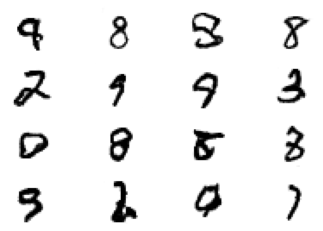



epoch -> [168/200], discriminator_loss_for_real_data = 254.64, discriminator_loss_for_fake_data = 242.17, generator_loss = 549.06



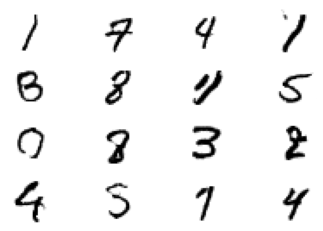



epoch -> [169/200], discriminator_loss_for_real_data = 254.29, discriminator_loss_for_fake_data = 241.92, generator_loss = 548.05



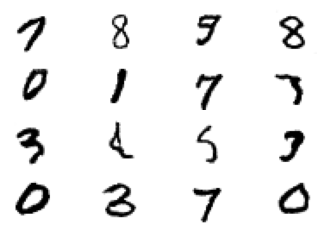



epoch -> [170/200], discriminator_loss_for_real_data = 253.40, discriminator_loss_for_fake_data = 240.94, generator_loss = 556.47



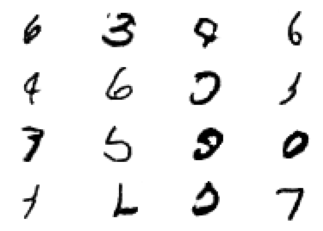



epoch -> [171/200], discriminator_loss_for_real_data = 252.97, discriminator_loss_for_fake_data = 240.14, generator_loss = 556.38



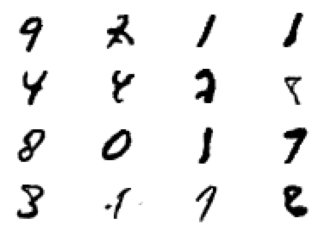



epoch -> [172/200], discriminator_loss_for_real_data = 251.79, discriminator_loss_for_fake_data = 238.19, generator_loss = 556.98



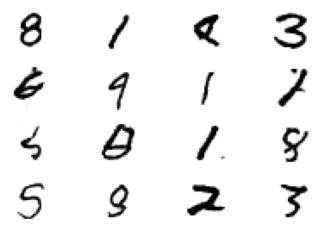



epoch -> [173/200], discriminator_loss_for_real_data = 254.12, discriminator_loss_for_fake_data = 239.04, generator_loss = 558.06



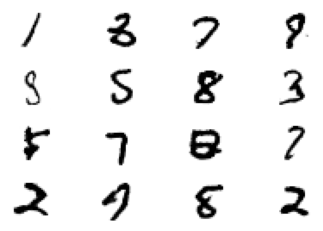



epoch -> [174/200], discriminator_loss_for_real_data = 251.04, discriminator_loss_for_fake_data = 237.74, generator_loss = 560.90



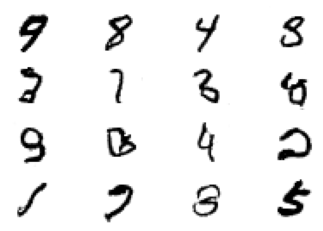



epoch -> [175/200], discriminator_loss_for_real_data = 250.36, discriminator_loss_for_fake_data = 237.11, generator_loss = 563.63



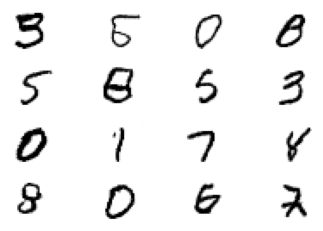



epoch -> [176/200], discriminator_loss_for_real_data = 250.50, discriminator_loss_for_fake_data = 236.80, generator_loss = 564.92



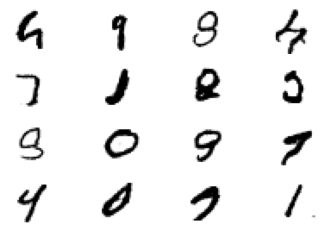



epoch -> [177/200], discriminator_loss_for_real_data = 249.75, discriminator_loss_for_fake_data = 236.88, generator_loss = 566.67



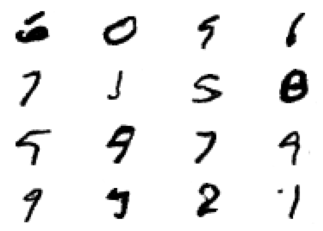



epoch -> [178/200], discriminator_loss_for_real_data = 249.29, discriminator_loss_for_fake_data = 235.21, generator_loss = 572.69



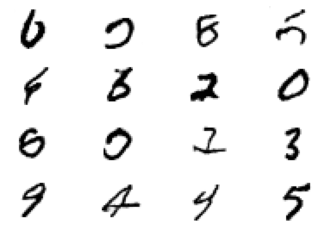



epoch -> [179/200], discriminator_loss_for_real_data = 249.12, discriminator_loss_for_fake_data = 234.79, generator_loss = 570.87



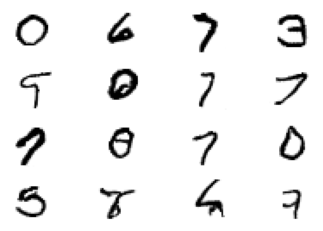



epoch -> [180/200], discriminator_loss_for_real_data = 246.73, discriminator_loss_for_fake_data = 232.88, generator_loss = 577.79



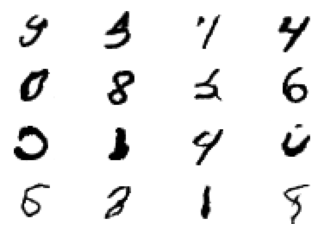



epoch -> [181/200], discriminator_loss_for_real_data = 248.28, discriminator_loss_for_fake_data = 234.80, generator_loss = 580.92



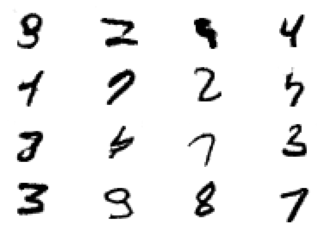



epoch -> [182/200], discriminator_loss_for_real_data = 247.29, discriminator_loss_for_fake_data = 235.05, generator_loss = 581.27



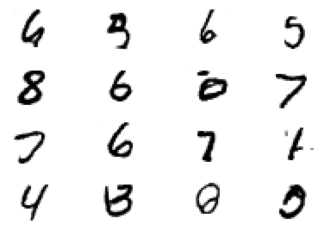



epoch -> [183/200], discriminator_loss_for_real_data = 246.54, discriminator_loss_for_fake_data = 232.12, generator_loss = 583.48



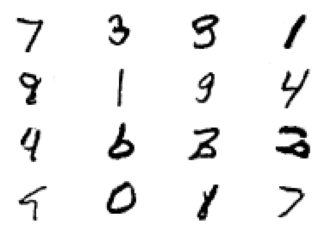



epoch -> [184/200], discriminator_loss_for_real_data = 245.80, discriminator_loss_for_fake_data = 232.77, generator_loss = 583.85



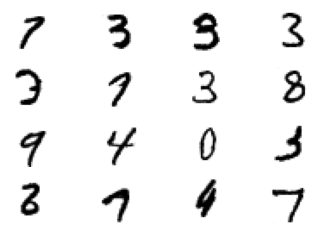



epoch -> [185/200], discriminator_loss_for_real_data = 244.80, discriminator_loss_for_fake_data = 230.72, generator_loss = 587.69



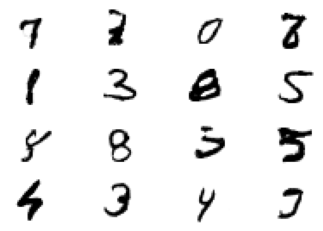



epoch -> [186/200], discriminator_loss_for_real_data = 243.59, discriminator_loss_for_fake_data = 229.42, generator_loss = 591.11



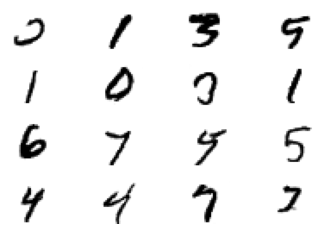



epoch -> [187/200], discriminator_loss_for_real_data = 243.09, discriminator_loss_for_fake_data = 229.07, generator_loss = 596.36



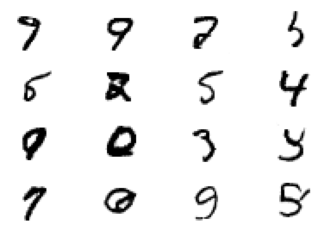



epoch -> [188/200], discriminator_loss_for_real_data = 244.40, discriminator_loss_for_fake_data = 230.35, generator_loss = 593.80



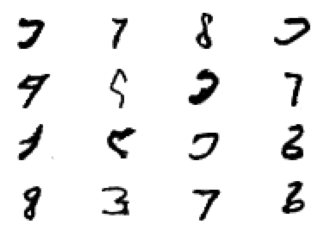



epoch -> [189/200], discriminator_loss_for_real_data = 244.84, discriminator_loss_for_fake_data = 231.20, generator_loss = 591.10



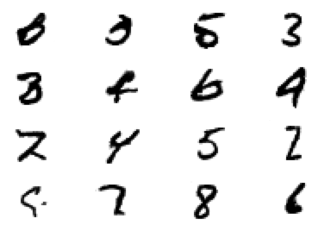



epoch -> [190/200], discriminator_loss_for_real_data = 243.67, discriminator_loss_for_fake_data = 230.10, generator_loss = 593.96



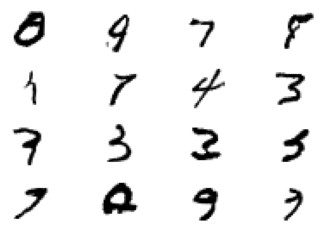



epoch -> [191/200], discriminator_loss_for_real_data = 241.23, discriminator_loss_for_fake_data = 228.19, generator_loss = 600.86



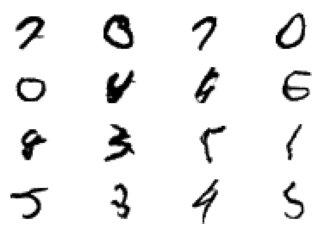



epoch -> [192/200], discriminator_loss_for_real_data = 242.73, discriminator_loss_for_fake_data = 227.22, generator_loss = 607.23



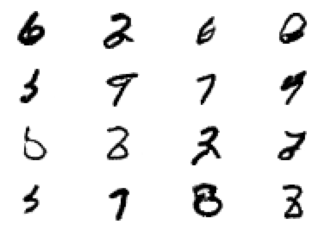



epoch -> [193/200], discriminator_loss_for_real_data = 240.62, discriminator_loss_for_fake_data = 225.51, generator_loss = 610.59



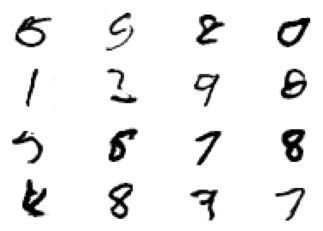



epoch -> [194/200], discriminator_loss_for_real_data = 239.88, discriminator_loss_for_fake_data = 226.63, generator_loss = 607.78



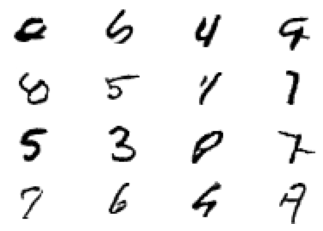



epoch -> [195/200], discriminator_loss_for_real_data = 239.71, discriminator_loss_for_fake_data = 224.61, generator_loss = 611.51



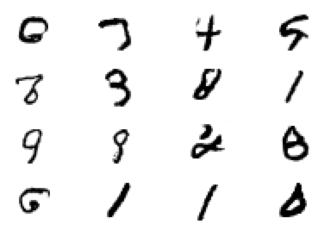



epoch -> [196/200], discriminator_loss_for_real_data = 239.95, discriminator_loss_for_fake_data = 223.88, generator_loss = 609.14



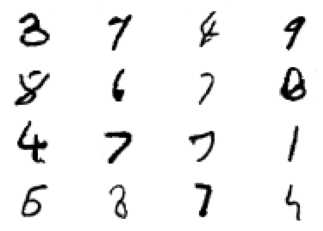



epoch -> [197/200], discriminator_loss_for_real_data = 236.96, discriminator_loss_for_fake_data = 222.69, generator_loss = 612.93



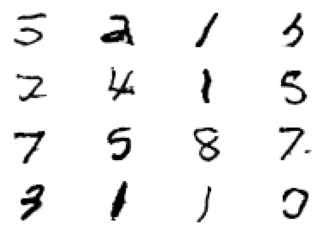



epoch -> [198/200], discriminator_loss_for_real_data = 238.71, discriminator_loss_for_fake_data = 224.85, generator_loss = 617.91



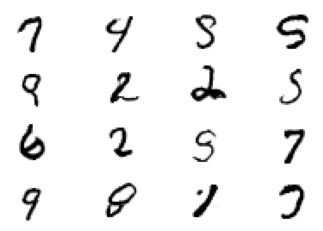



epoch -> [199/200], discriminator_loss_for_real_data = 240.10, discriminator_loss_for_fake_data = 226.53, generator_loss = 617.27



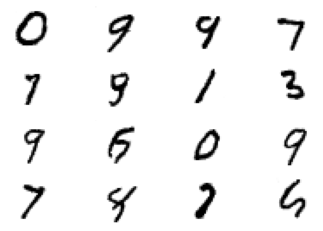



epoch -> [200/200], discriminator_loss_for_real_data = 236.04, discriminator_loss_for_fake_data = 223.10, generator_loss = 620.95



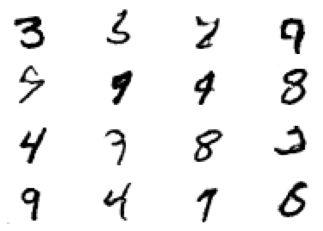

In [51]:
with tf.device(device_name):

  latent_dim = 100
  n_epochs = 200
  d_model = define_discriminator()
  g_model = define_generator(latent_dim)
  gan_model = define_gan(g_model, d_model)
  dataset = load_real_samples()
  print('\nREADY TO GO !!!\n')
  
  d_loss_r, d_loss_f, g_loss = train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs)

## Plot Loss Values

In [52]:
loaded = np.load('/content/drive/MyDrive/GAN_New_Approch/1/loss_record.npz')
print(loaded['a'].shape)
print(loaded['b'].shape)
print(loaded['c'].shape)

(200,)
(200,)
(200,)


In [53]:
import matplotlib.pyplot as plot

g_loss = np.array(loaded['c'])

In [54]:
d_loss = np.array([(i+j) for i,j in zip(loaded['a'], loaded['b'])])

In [55]:
# print(d_loss_r)
# print(d_loss_f)
# print(d_loss)
# print(g_loss)

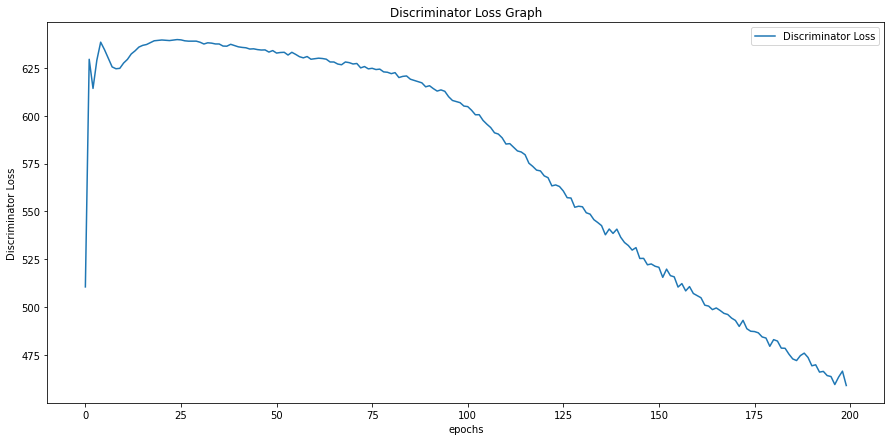

In [56]:
plt.figure(figsize=(15,7))
plt.plot(d_loss)
plt.title('Discriminator Loss Graph')
plt.ylabel('Discriminator Loss')
plt.xlabel('epochs')
plt.legend(["Discriminator Loss"], loc='upper right')
plt.show()

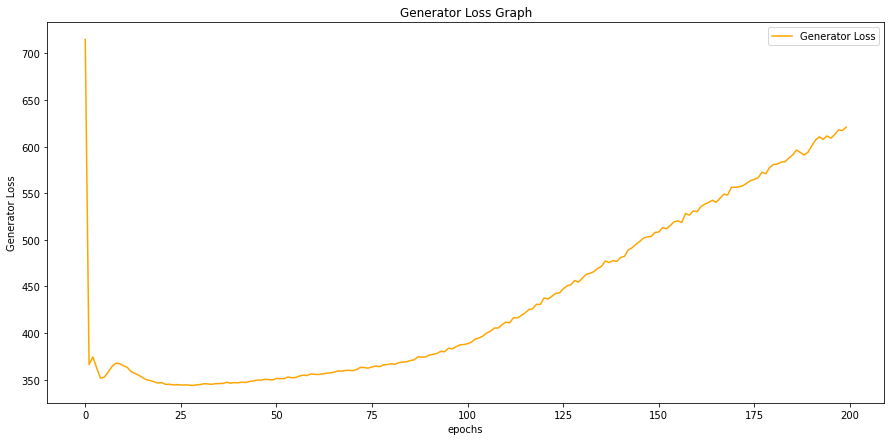

In [57]:
plt.figure(figsize=(15,7))
plt.plot(g_loss,color='orange')
plt.title('Generator Loss Graph')
plt.ylabel('Generator Loss')
plt.xlabel('epochs')
plt.legend(["Generator Loss"], loc='upper right')
plt.show()

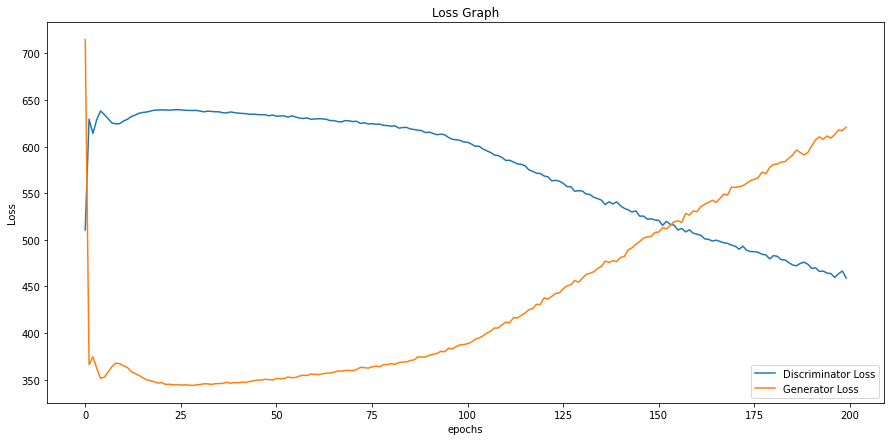

In [58]:
plt.figure(figsize=(15,7))
plt.plot(d_loss)
plt.plot(g_loss)
plt.title('Loss Graph')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend(["Discriminator Loss", "Generator Loss"], loc='lower right')
plt.show()

# Prediction

latent points(latent points and labels):  (16, 100) (16,)

Generated images with labels:  (16, 28, 28, 1) 



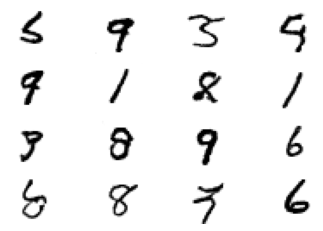

In [59]:
latent_dim = 100
n_samples = 16
z_input, labels = generate_latent_points(latent_dim, n_samples)
print("latent points(latent points and labels): ",z_input.shape, labels.shape)
data = [z_input,labels]
pred = g_model.predict(data)
pred = (pred +1 ) / 2.0
print("\nGenerated images with labels: ",pred.shape,'\n')
save_plot(pred,labels,n=4)

                                              -:END:-

In [60]:
# import numpy as np
# test_array = np.random.rand(3, 2)
# test_vector = np.random.rand(4)
# test_vector_1 = np.random.rand(4,1,4,2)
# np.savez_compressed('ok.npz', a=test_array, b=test_vector, c=test_vector_1)
# loaded = np.load('ok.npz')
# print(loaded['a'].shape)
# print(loaded['b'].shape)
# print(loaded['c'].shape)